# Obesity Risk Prediction using Tree-based models

This notebook trains tree-based models to predict obesity levels based on multi-class classification. Baseline decision trees, random forests and XGBoost models will be used.

In [2]:
# Importing libraries 
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load split data from feather files
train_path = os.path.join("..", "processed_data", "train_data.feather")
test_path = os.path.join("..", "processed_data", "test_data.feather")

train_df = pd.read_feather(train_path)
test_df = pd.read_feather(test_path)

# Split features and labels again
y_train = train_df["obesity_level"]
X_train = train_df.drop(columns=["obesity_level"])

y_test = test_df["obesity_level"]
X_test = test_df.drop(columns=["obesity_level"])


In [37]:
# Define numerical columns
numerical_cols = X_train.select_dtypes(include=["float64"]).columns

# Separate nominal and ordinal categorical features
nominal_cols = [
    'gender', 
    'family_history_overweight', 
    'smokes', 
    'calorie_tracking', 
    'transport_mode'
]

ordinal_cols = [
    'high_caloric_food_freq', 
    'vegetables_freq', 
    'main_meal_count', 
    'snacking_freq', 
    'water_intake', 
    'physical_activity_freq', 
    'screen_time_hours', 
    'alcohol_consumption_freq'
]

In [38]:
# Define the preprocessing steps with proper encoding for each type
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),
        ("nom", OneHotEncoder(handle_unknown='ignore'), nominal_cols),
        ("ord", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ordinal_cols)
    ]
)

##### While DecisionTreeClassifier and RandomForestClassifier can work with both numeric and string labels, XGBoostClassifier expects numeric class labels. Therefore we encode the targets into integers. After making the predictions, we'll convert the predicted integers back to labels for evaluation.

In [39]:
# Create encoder
label_encoder = LabelEncoder()

# Fit and transform the target variable
y_train_encoded = label_encoder.fit_transform(y_train)

#### Decision Trees

Best parameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 15, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Best cross-validation accuracy: 0.9479

Test Set Performance:
Accuracy: 0.9645


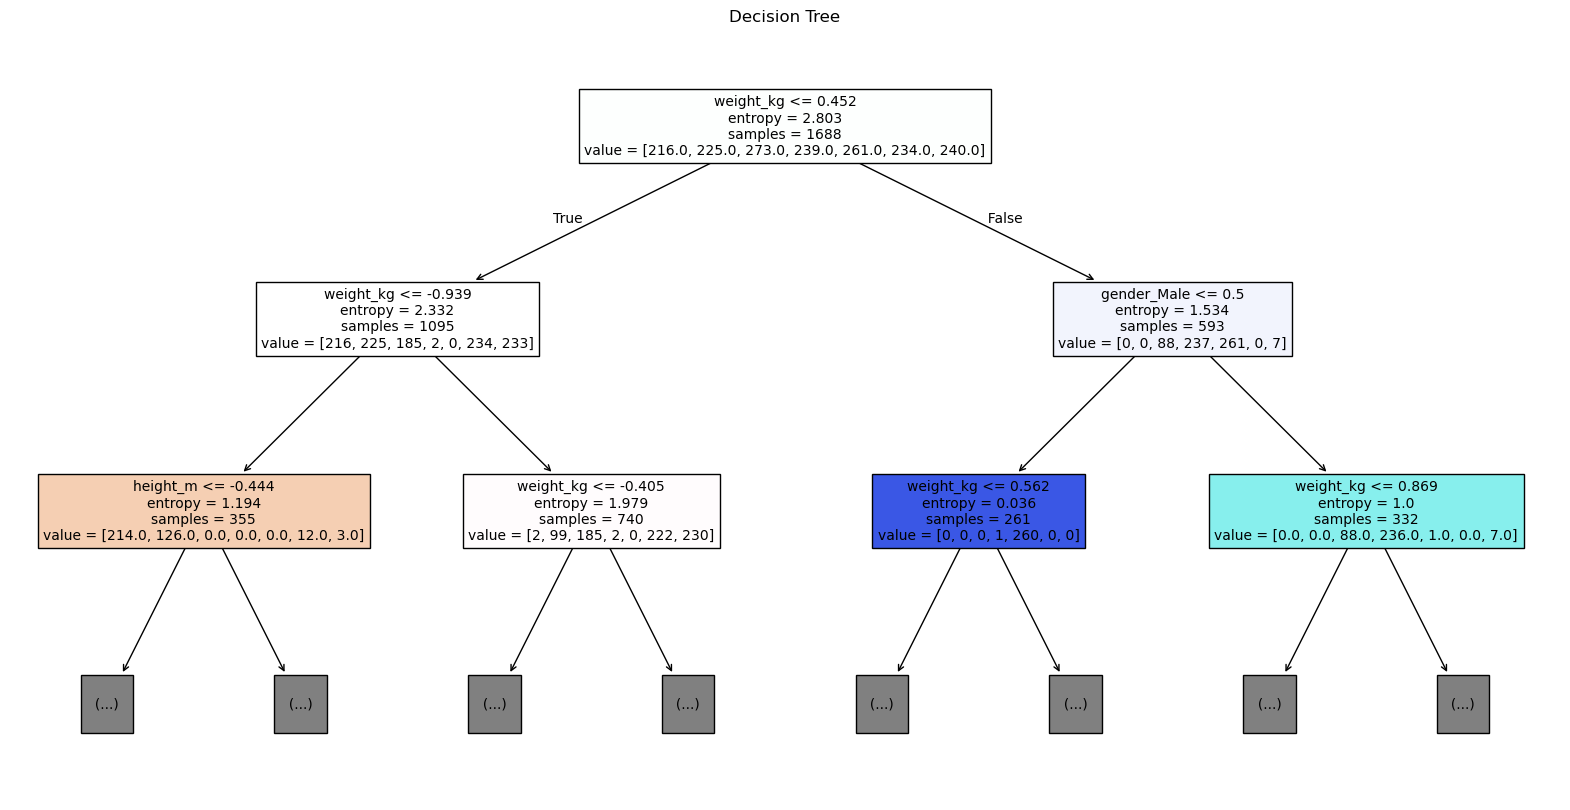


Top 5 Important Features:
                   Feature  Importance
2                weight_kg    0.624868
1                 height_m    0.196542
4              gender_Male    0.120838
0                      age    0.023658
16  high_caloric_food_freq    0.009961


In [46]:
# Create pipeline
pipeline_dt = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Define parameter grid for hyperparameter tuning
param_grid = {
    'classifier__max_depth': [3, 5, 7, 10, 15, 20, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__criterion': ['gini', 'entropy']
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline_dt, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model
best_dt = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

# Evaluate on test set
y_pred = best_dt.predict(X_test)
print("\nTest Set Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")



# Plot the decision tree
# Get names of features after transformation
num_features = numerical_cols

# Get nominal feature names (one-hot encoded)
nom_features = best_dt.named_steps['preprocessor']\
                     .named_transformers_['nom']\
                     .get_feature_names_out(nominal_cols)

# Get ordinal feature names
ord_features = ordinal_cols  # These keep their original names in OrdinalEncoder

# Combine all feature names
feature_names = np.concatenate([num_features, nom_features, ord_features])

plt.figure(figsize=(20, 10))
plot_tree(best_dt.named_steps['classifier'], 
          feature_names=feature_names, 
          filled=True, 
          max_depth=2,  # optional: controls depth of tree in plot
          fontsize=10)
plt.title("Decision Tree")
plt.savefig("../plots/decision_tree_visualization.png", dpi=300, bbox_inches='tight')
plt.show()

# Feature Importance
importance = best_dt.named_steps['classifier'].feature_importances_
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the top features
print("\nTop 5 Important Features:")
print(importance_df.head(5))  # Adjust the number of top features as needed


#### Add plots and markdown explanation cells

#### Random Forest

In [42]:
# Create pipeline
pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))
])

# Define parameter grid for hyperparameter tuning
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2']
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline_rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model
best_rf = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

# Evaluate on test set
y_pred = best_rf.predict(X_test)
print("\nTest Set Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

# Helper function to get feature names after preprocessing
def get_feature_names(column_transformer):
    """Get feature names from a ColumnTransformer"""
    col_names = []
    for transformer_in_columns in column_transformer.transformers_:
        transformer_name, transformer, orig_columns = transformer_in_columns
        if transformer == 'drop':
            continue
        if hasattr(transformer, 'get_feature_names_out'):
            names = transformer.get_feature_names_out(orig_columns)
        else:  # for StandardScaler
            names = orig_columns
        col_names.extend(names)
    return col_names

# Feature importance
feature_importances = best_rf.named_steps['classifier'].feature_importances_
features = get_feature_names(best_rf.named_steps['preprocessor'])

# Create DataFrame for feature importances
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

print("\nTop 5 Important Features:")
print(importance_df.head(5))

Best parameters: {'classifier__max_depth': 20, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Best cross-validation accuracy: 0.9348

Test Set Performance:
Accuracy: 0.9362

Top 5 Important Features:
            Feature  Importance
2         weight_kg    0.333455
0               age    0.113978
1          height_m    0.110533
4       gender_Male    0.048949
17  vegetables_freq    0.042443


### NB: Use scikit-learn version 1.5.2: add to requirements.txt

#### XGBoost

In [43]:
# Create pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42, n_jobs=1, 
                                objective='multi:softmax',
                                eval_metric='mlogloss'))
])

# Define parameter grid for hyperparameter tuning
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [3, 5, 7, 10],
    'classifier__learning_rate': [0.01, 0.1, 0.2]
    #'classifier__subsample': [0.8, 1.0],
    #'classifier__colsample_bytree': [0.8, 1.0],
    #'classifier__gamma': [0, 0.1, 0.2]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=1)
grid_search.fit(X_train, y_train_encoded)

# Get the best model
best_xgb = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

# Evaluate on test set
y_pred = best_xgb.predict(X_test)
y_pred = label_encoder.inverse_transform(y_pred)
print("\nTest Set Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

# Feature importance
feature_importances = best_xgb.named_steps['classifier'].feature_importances_
features = get_feature_names(best_xgb.named_steps['preprocessor'])

# Create DataFrame for feature importances
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

print("\nTop 5 Important Features:")
print(importance_df.head(5))

Best parameters: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 3, 'classifier__n_estimators': 200}
Best cross-validation accuracy: 0.9668

Test Set Performance:
Accuracy: 0.9574

Top 5 Important Features:
                     Feature  Importance
3              gender_Female    0.384989
2                  weight_kg    0.148926
16    high_caloric_food_freq    0.080496
23  alcohol_consumption_freq    0.065907
19             snacking_freq    0.047533


### Run the model without height and weight